In [32]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [33]:
%matplotlib inline

import os
import numpy as np
import h5py, json
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

In [34]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [38]:
dst_path = "/home/sobolev/nevermind/AG_Pecka/data/processed/"
rep_path = '/home/sobolev/nevermind/Andrey/analysis/manuscripts'

units_to_plot = [
    #['009266_hippoSIT_2023-04-18_17-03-10', '2-10'],
    ['009266_hippoSIT_2023-04-18_17-03-10', '2-11'],
    #['009265_hippoSIT_2023-03-05_11-52-17', '1-3'],
    ['009265_hippoSIT_2023-03-05_11-52-17', '2-6'],
    #['009265_hippoSIT_2023-03-05_11-52-17', '2-7'],
    #['009265_hippoSIT_2023-03-08_18-10-07', '1-8'],
    #['009265_hippoSIT_2023-03-08_18-10-07', '1-9'],
    #['009265_hippoSIT_2023-03-08_18-10-07', '1-11'],
    ['009265_hippoSIT_2023-03-08_18-10-07', '1-16'],
    ['009265_hippoSIT_2023-03-08_18-10-07', '2-15'],
    #['009265_hippoSIT_2023-03-08_18-10-07', '2-17'],
    #['57_SIT_2024-01-05_15-08-34', '1-5'],
    ['57_SIT_2024-01-05_15-08-34', '1-6'],
    ['57_SIT_2024-01-05_15-08-34', '1-9'],
    ['57_SIT_2024-01-05_15-08-34', '1-14'],
    #['57_SIT_2024-01-05_15-08-34', '1-16']
]

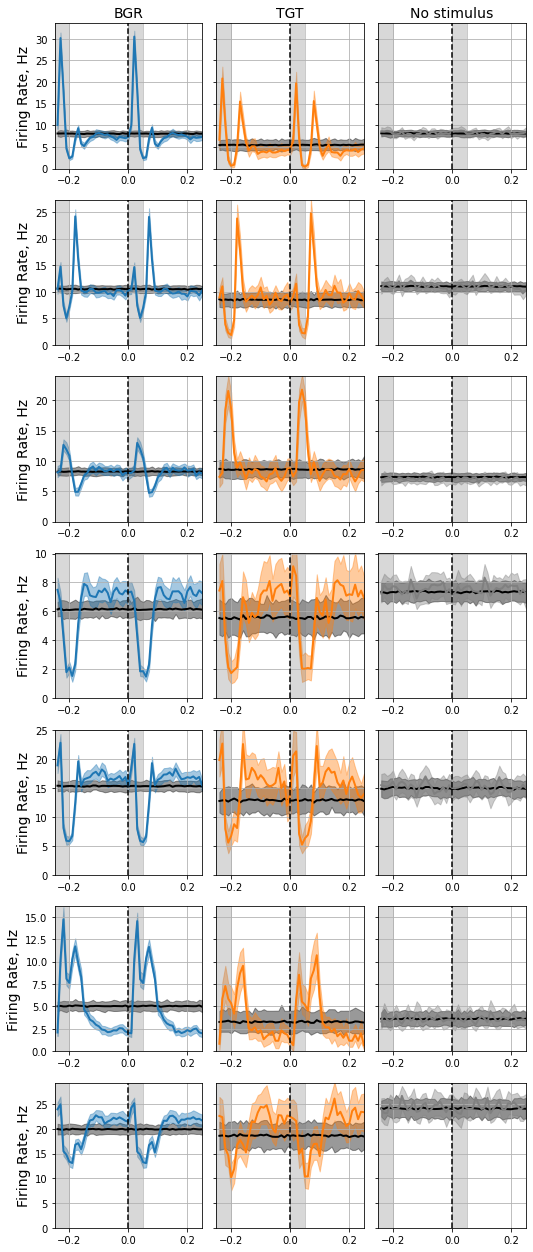

In [39]:
event_types = [1, 2, 0]
ev_names = {0: 'SIL', 1: 'BGR', 2: 'TGT', -1: 'NOI'}
titles = {0: 'No stimulus', 1: 'BGR', 2: 'TGT'}
colors = {0: 'grey', 1: 'tab:blue', 2: 'tab:orange', -1: 'red'}  # 'indigo'

rows = len(units_to_plot)
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(2.5*cols, 2.5*rows))

for i, record in enumerate(units_to_plot):
    unit_name = record[1]
    session = record[0]
    animal   = session.split('_')[0]
    session_path = os.path.join(dst_path, animal, session)
    psth_file  = os.path.join(session_path, 'analysis', 'psth_micro.h5')
    shuf_file  = os.path.join(session_path, 'analysis', 'shuffle_micro.h5')
    meta_file  = os.path.join(session_path, 'meta.h5')
    
    with h5py.File(meta_file, 'r') as f:
        cfg = json.loads(f['processed'].attrs['parameters'])
    bgr_dur = cfg['sound']['sounds']['background']['duration']  # in seconds
    latency = cfg['sound']['latency']

    y_max = 0
    for j, ev_type in enumerate(event_types):
    
        # read PSTH profile
        with h5py.File(psth_file, 'r') as f:
            # bins, shuffled mean, std, perc 5, perc 95
            profile_stats = np.array(f[ev_names[ev_type]][unit_name]['profile_stats'])
        
        # read shuffled stats
        with h5py.File(shuf_file, 'r') as f:
            # bins, shuffled mean, std, perc 5, perc 95
            shuffled = np.array(f[ev_names[ev_type]][unit_name]['shuffled'])
        
        ax = axes[i][j]
        for k, c_stats in enumerate([shuffled, profile_stats]):
            bin_size = c_stats[0][1] - c_stats[0][0]
            clr = colors[ev_type] if k == 1 else 'black'
            label = ev_names[ev_type] if k == 1 else 'shuffle'
            ax.plot(c_stats[0] + bin_size, c_stats[1], color=clr, lw=2, label=label)
            ax.fill_between(c_stats[0] + bin_size, c_stats[3], c_stats[4], color=clr, alpha=0.4)
            
            if c_stats[1].max() > y_max:
                y_max = c_stats[1].max()
                
        ax.set_xlim(-latency, latency)
        ax.axvline(0, color='black', ls='--')
        #ax.set_title("%s" % unit_name, fontsize=14)
        ax.axvspan(0, bgr_dur, alpha=0.3, color='gray')
        ax.axvspan(-latency, -latency + bgr_dur, alpha=0.3, color='gray')
        if j > 0:
            ax.set_yticklabels([])
        #ax.legend()
        ax.grid()

    for j, ax in enumerate(axes[i]):
        ax.set_ylim(0, 1.1*y_max)
        if i == 0:
            ax.set_title(titles[event_types[j]], fontsize=14)
    axes[i][0].set_ylabel("Firing Rate, Hz", fontsize=14)
            
fig.tight_layout()
fig.savefig(os.path.join(rep_path, 'PSTH_examples.png'), dpi=300)